# Building embeddings from our corpus

Now we have our corpus, we can build our embeddings.

There are different types of embeddings. At our corpus we will work with word embeddings. However we could think of sentence embeddings, paragraph embeddings, document embeddings, even character or subword embeddings.

Word embeddings are vector representations of words. They are useful for many NLP tasks, such as sentiment analysis, text classification, and machine translation. They are also useful for visualising the relationships between words. For example, we can use them to find words with similar meanings, or to find words that are often used together.

## Why do we need embeddings?

Computers and most machine learnign algorithms in particular work better with numerical data. However, words are not numbers. So we need to find a way to represent words as numbers.

Large Language Models such as ChatGPT also use word embeddings to represent words. However, they are trained on huge amounts of data, and so are not always suitable for smaller projects. In this notebook, we will build our own word embeddings from our corpus.

## Different types of embedddings

There are different types of word embeddings as well, such as:

- Word2Vec
- GloVe
- FastText
- BERT

 We will  also use the gensim library to do this. Gensim is a library for topic modelling, document indexing and similarity retrieval with large corpora. It uses the word2vec algorithm to create vector representations of words, which can then be used to find words with similar meanings.

In [2]:
# We will be using the same dataset as in the previous notebook
# usual standard imports
from pathlib import Path
from datetime import datetime

#python version
import sys
print("Python ver:", sys.version)


import pandas as pd
# print version
print("Pandas ver:", pd.__version__)

# we will need gensim for word2vec embeddings
import gensim
# print version
print("Gensim ver:", gensim.__version__)

# we will need scikit learn for tfidf embeddings
import sklearn
# print version
print("Scikit learn ver:", sklearn.__version__)

Python ver: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Pandas ver: 2.0.3
Gensim ver: 4.3.1
Scikit learn ver: 1.3.0


## Loading Data from Parquet Url

In [19]:
# now let's load parquet file directly from url
url = "https://github.com/ValRCS/BSSDH_2023_workshop/raw/main/data/old_bailey_sample_1720_1913_cleaned.parquet"
df = pd.read_parquet(url)
print("Dataframe shape:", df.shape)

Dataframe shape: (1637, 9)


In [4]:
# how much memory does this dataframe use?
print("Dataframe size:", df.memory_usage(deep=True).sum())
# supposedly Pandas 2.0 has better memory management for strings


Dataframe size: 5686694


In [5]:
# let's get some statistics about our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1637 entries, 1720 to 1913
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   trial_number        1637 non-null   int64 
 1   punishment          1162 non-null   object
 2   text                1637 non-null   object
 3   dirty_len           1637 non-null   int64 
 4   clean_len           1637 non-null   int64 
 5   words               1637 non-null   object
 6   word_count          1637 non-null   int64 
 7   word_count_cleaned  1637 non-null   int64 
 8   words_lemmatized    1637 non-null   object
dtypes: int64(5), object(4)
memory usage: 127.9+ KB


In [6]:
# we can get basic statistics about our dataframe
df.describe() # for numerical columns - returns a dataframe as well

,trial_number,dirty_len,clean_len,word_count,word_count_cleaned
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,49.329872,3227.827734,3091.967013,608.543677,257.531460
std,34.327506,7288.101079,7020.877032,1376.101195,544.264694
min,1.000000,57.000000,51.000000,10.000000,6.000000
25%,22.000000,302.000000,285.000000,50.000000,31.000000
50%,44.000000,1359.000000,1291.000000,245.000000,115.000000
75%,70.000000,3453.000000,3299.000000,654.000000,277.000000
max,173.000000,161044.000000,156144.000000,29928.000000,11270.000000


In [16]:
# random sample of 5 rows
# let's set seed first
import numpy as np
np.random.seed(2023) # so we will get the same results
df.sample(5)

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized
year,,,,,,,,,
1896,37,Eighteen Months' Hard Labour.,95 john leigh 40 unlawfully obtaining from wal...,18027,17288,"[95, john, leigh, 40, unlawfully, obtaining, w...",3237,1466,"[95, john, leigh, 40, unlawfully, obtain, walt..."
1841,71,Confined Three Months,368 john johnson was indicted for stealing on ...,192,179,"[368, john, johnson, indicted, stealing, 9th, ...",34,23,"[368, john, johnson, indict, steal, 9th, decem..."
1762,19,None,107 m eleanor coshee otherwise southwall late ...,3708,3544,"[107, m, eleanor, coshee, southwall, late, par...",704,312,"[107, m, eleanor, coshee, southwall, late, par..."
1835,2,DEATH,186 josiah allen was indicted for burglariousl...,3395,3260,"[186, josiah, allen, indicted, burglariously, ...",655,275,"[186, josiah, allen, indict, burglariously, br..."
1731,49,[Transportation. See summary.],william simpson of st jamess clerkenwell was i...,3557,3428,"[william, simpson, st, jamess, clerkenwell, in...",667,261,"[william, simpson, st, jamess, clerkenwell, in..."


<Axes: >

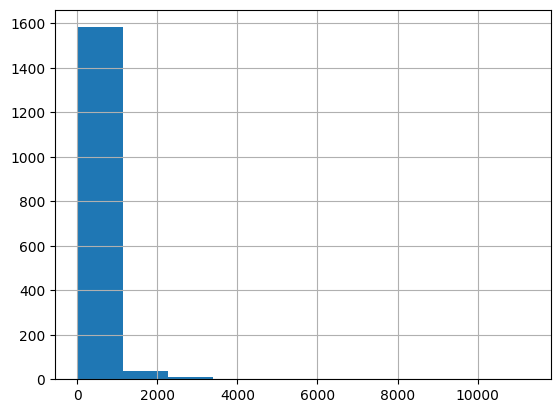

In [7]:
# we might want to plot histogram of word_count_cleaned
# this will give us a more detailed view of the distribution of word counts
df.word_count_cleaned.hist() # this will plot histogram of word counts 

In [8]:
# looks like we have some outliers, let's see what they are
df[df.word_count_cleaned > 10000]
# looks like there was a very long trial that ended up badly for the defendant

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized
year,,,,,,,,,
1872,1,DEATH,117 john selby watson 67 was indicted for the ...,161044,156144,"[117, john, selby, watson, 67, indicted, wilfu...",29928,11270,"[117, john, selby, watson, 67, indict, wilful,..."


<Axes: >

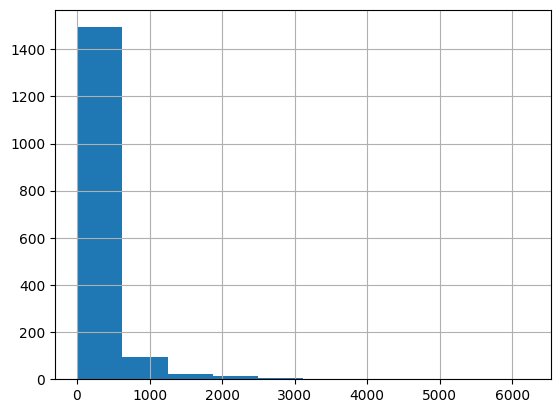

In [9]:
# for our histogram we will skip this outlier
df[df.word_count_cleaned < 10000].word_count_cleaned.hist()

<Axes: >

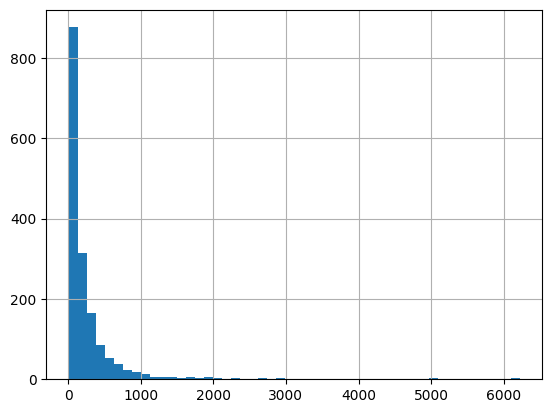

In [10]:
# we are still not getting a good view of the distribution
# let's increase the number of bins
df[df.word_count_cleaned < 10000].word_count_cleaned.hist(bins=50)


<Axes: >

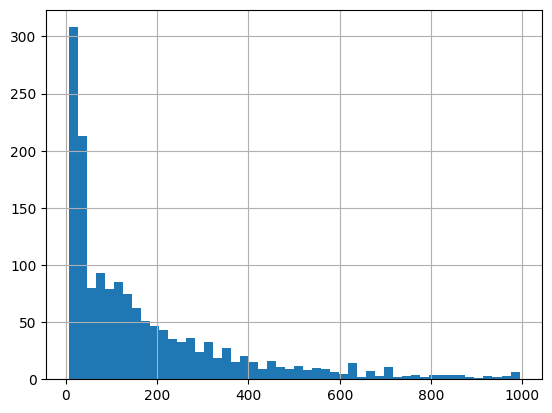

In [11]:
# again we can see that most of the documents are short
# certainly Justice in England was swift and brutal

# let's see distribution among shorter documents of less than 1000 words
df[df.word_count_cleaned < 1000].word_count_cleaned.hist(bins=50)

## Concerns on short texts

Short texts might not have enough information to build good embeddings. However, we will try to build them anyway.

In [ ]:
# I am concerned that we will not get very useful embeddings from the very short documents but for now we will leave them in

# Also I noticed that our cleaning still left numerical digits in the text
# sometimes they are important, but in general we can remove them

In [22]:
# let's remove digits from our words_lemmatized column that contains list of wordsd
# let's build a function that will remove any digits in from a list of words
def remove_digits(words):
    """Removes digits from a list of words"""
    return [word for word in words if not word.isdigit()]
# let's apply it to our dataframe
df.words_lemmatized = df.words_lemmatized.apply(remove_digits)
# let's make a column with word count after removing digits
df["word_count_cleaned_no_digits"] = df.words_lemmatized.apply(len)
# let's see how many documents we have now
df.shape
# how many words did we remove?
print("Words removed with digits only:", df.word_count_cleaned.sum() - df.word_count_cleaned_no_digits.sum())
# total words remaining
print("Total words remaining:", df.word_count_cleaned_no_digits.sum())
# this will make our embeddings smaller and faster to train

Words removed with digits only: 12700
Total words remaining: 408879


In [26]:
# we might still have words that contain a digit in them let's remove those as well
# let's build a function that will remove any words that contain digits
def remove_words_with_digits(words):
    """Removes words that contain digits from a list of words"""
    return [word for word in words if not any(char.isdigit() for char in word)] # this is slower but more general that previous function

# let's apply it to our dataframe
# start of timer
start = datetime.now()
print(f"Start time: {start}")
df.words_lemmatized = df.words_lemmatized.apply(remove_words_with_digits)
print(f"Time elapsed: {datetime.now() - start}")
# let's update our word count cleaned no digits column
df["word_count_cleaned_no_digits"] = df.words_lemmatized.apply(len)
# let's see how many documents we have now
print("Documents:", df.shape[0])
# how many words did we remove?
print("Words removed with digits only:", df.word_count_cleaned.sum() - df.word_count_cleaned_no_digits.sum())
# total words remaining
print("Total words remaining:", df.word_count_cleaned_no_digits.sum())

Start time: 2023-07-25 00:47:10.754756
Time elapsed: 0:00:00.134627
Documents: 1637
Words removed with digits only: 19435
Total words remaining: 402144


## Bag of Words

The simplest way to build embeddings is to use a bag of words model. This is a simple model that counts the number of times each word appears in a document. It then uses these counts to build a vector representation of the document.

We will use the gensim library to build our embeddings. Gensim is a library for topic modelling, document indexing and similarity retrieval with large corpora. It uses the word2vec algorithm to create vector representations of words, which can then be used to find words with similar meanings.

In [45]:
# we can use scikit learn count vectorizer to get a bag of words representation
from sklearn.feature_extraction.text import CountVectorizer

# now we will use CountVectorizer to get a bag of words representation

# we will use the words_lemmatized column
# we will use the default tokenizer
# we will use the default vocabulary
# we will use the default ngram_range

# let's create an instance of CountVectorizer
count_vectorizer = CountVectorizer() # there area many custom parameters we can set, but we will use defaults for now
# if you check the documentation you will see that many of the tasks we did previously can be done with CountVectorizer such as tokenization, stopword removal, etc.
# docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# let's fit it to our words_lemmatized column
# we will need to convert it back to a string with space separated words
# we can use apply and join to do this
count_vectorizer.fit(df.words_lemmatized.apply(" ".join)) # fit is often used in scikit learn to learn the vocabulary, fit is also used in training models
# above might seem a bit wasteful, but it is a common pattern in scikit learn

# let's see what we have in our vocabulary
# how many unique words do we have?
print("Word count in bow vectorizer", len(count_vectorizer.vocabulary_)) # this will return a dictionary with words as keys and their index as values
# first 20 words
list(count_vectorizer.vocabulary_.items())[:20]# this will return a dictionary with words as keys and their index as values

Word count in bow vectorizer 18093


[('st', 15191),
 ('leonard', 9450),
 ('eastcheap', 5131),
 ('indict', 8306),
 ('feloniously', 5881),
 ('steal', 15305),
 ('pound', 12590),
 ('weight', 17460),
 ('tobacco', 16298),
 ('value', 16988),
 ('good', 6844),
 ('job', 8747),
 ('wick', 17671),
 ('dwelling', 5084),
 ('house', 7957),
 ('say', 14094),
 ('april', 626),
 ('appear', 583),
 ('prisoner', 12747),
 ('prosecutor', 12842)]

In [30]:
# how many unique words do we have?
len(count_vectorizer.vocabulary_)

18093

In [33]:
# can we get a bag of words representation for a single document?
# let's get the first document
# get words from first row
first_doc = df.words_lemmatized.iloc[0] # iloc is used to get row by numerical index
# let's see what it looks like
first_doc

['st',
 'leonard',
 'eastcheap',
 'indict',
 'feloniously',
 'steal',
 'pound',
 'weight',
 'tobacco',
 'value',
 'l',
 's',
 'good',
 'job',
 'wick',
 'dwelling',
 'house',
 'say',
 'job',
 'wick',
 'april',
 'appear',
 'prisoner',
 'prosecutor',
 'servant',
 'fellow',
 'servant',
 'depose',
 'perceive',
 'pocket',
 'stick',
 'search',
 'find',
 'paper',
 'tobacco',
 'worth',
 'd',
 'own',
 'master',
 'take',
 'cellar',
 'constable',
 'depose',
 'confest',
 'take',
 'tobacco',
 'time',
 'say',
 'paper',
 'tobacco',
 'produce',
 'court',
 'jury',
 'consider',
 'matter',
 'find',
 'guilty',
 'value',
 'd',
 'transportation']

In [36]:
# let's get bag of words representation of first document
first_doc_bow = count_vectorizer.transform([" ".join(first_doc)]) # we need to pass a list of documents
# this will return a sparse matrix
first_doc_bow

<1x18093 sparse matrix of type '<class 'numpy.int64'>'
	with 44 stored elements in Compressed Sparse Row format>

In [37]:
# print element indexes of sparse matrix
print(first_doc_bow.indices)
# sparse matrix is a matrix that has many zero elements so those are generally not stored and are skipped

[  583   626  2732  3513  3577  3595  3837  4445  5084  5131  5870  5881
  5983  6844  7090  7957  8306  8747  8860  9450 10216 10239 11682 11770
 12050 12408 12590 12747 12786 12842 14094 14233 14364 15191 15305 15356
 15847 16262 16298 16468 16988 17460 17671 17956]


In [39]:
# what are those words from indices?
# we can use get_feature_names method
count_vectorizer.get_feature_names_out()[first_doc_bow.indices]

# note get_features_names was depreceated in favor of get_feature_names_out

# now results show that we have the same words as in our first document except the order is different
# here it looks like we have a bag of words representation for a single document in our corpus in an ordered list of words by lexical order

array(['appear', 'april', 'cellar', 'confest', 'consider', 'constable',
       'court', 'depose', 'dwelling', 'eastcheap', 'fellow',
       'feloniously', 'find', 'good', 'guilty', 'house', 'indict', 'job',
       'jury', 'leonard', 'master', 'matter', 'own', 'paper', 'perceive',
       'pocket', 'pound', 'prisoner', 'produce', 'prosecutor', 'say',
       'search', 'servant', 'st', 'steal', 'stick', 'take', 'time',
       'tobacco', 'transportation', 'value', 'weight', 'wick', 'worth'],
      dtype=object)

In [40]:
# we could create a huge sparse matrix for each document in our corpus
# however that would not be particularly useful
# we already saw that most of the words in our vocabulary are quite rare

# armed with these embbeddings we could compare documents by things like jaccard similarity
# jackquard similarity is a measure of how similar two sets are
# we could also use cosine similarity but that is a bit more complicated for now

# luckily we have many more options for creating embeddings beyond bag of words

## TF-IDF embeddings

TF-IDF is a widely used technique for text analysis. It stands for term frequency-inverse document frequency. It is a way of measuring how important a word is to a document in a collection of documents. It is often used to find keywords in a document.

TF-IDF consists of two parts: term frequency and inverse document frequency. Term frequency is the number of times a word appears in a document, while inverse document frequency is the number of documents in a collection that contain a word. The TF-IDF score is the product of these two numbers.

The idea is that first part - TF - is the number of times a word appears in a document, and the bottom part - IDF - is the number of documents in a collection that contain a word. The TF-IDF score is the product of these two numbers.

If IDF is high - this means the word is not particularly common in the collection of documents. If TF is high - this means the word is common in the document. So if a word is common in a document, but not common in the collection of documents, it will have a high TF-IDF score - ergo this word is common to the document, but not common to the collection of documents.

In [41]:
# we can use tfidf to create embeddings

# scikit learn has a tfidf vectorizer

# let's create an instance of tfidf vectorizer
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer() # there area many custom parameters we can set, but we will use defaults for now

In [43]:
# let's create tfidf embeddings for our corpus
# we will use the words_lemmatized column

# let's fit it to our words_lemmatized column
# we will need to convert it back to a string with space separated words

# we can use apply and join to do this
tfidf_vectorizer.fit(df.words_lemmatized.apply(" ".join)) # fit is often used in scikit learn to learn the vocabulary, fit is also used in training models

# let's see what we have in our vocabulary
# how many unique words do we have?
print("Unique words:", len(tfidf_vectorizer.vocabulary_))
# first 20 words
list(tfidf_vectorizer.vocabulary_.items())[:20]# this will return a dictionary with words as keys and their index as values

Unique words: 18093


[('st', 15191),
 ('leonard', 9450),
 ('eastcheap', 5131),
 ('indict', 8306),
 ('feloniously', 5881),
 ('steal', 15305),
 ('pound', 12590),
 ('weight', 17460),
 ('tobacco', 16298),
 ('value', 16988),
 ('good', 6844),
 ('job', 8747),
 ('wick', 17671),
 ('dwelling', 5084),
 ('house', 7957),
 ('say', 14094),
 ('april', 626),
 ('appear', 583),
 ('prisoner', 12747),
 ('prosecutor', 12842)]

In [47]:
# Attentive of you have noticed that both bow and tfidf vectorizers have the same vocabulary, which makes sense as we used same data to fit them
# also we used same hyper parameters for fitting so they should be the same 
# in this case we used default hyper parameters - which means we only used unigrams

# now let's create tifidf embeddings for our corpus

# we will use the transform method

# let's get the first document
# get words from first row
first_doc = df.words_lemmatized.iloc[0] # iloc is used to get row by numerical index
# let's see what it looks like
# show tfidf embeddings for first document
sparse_tfidf_first_doc = tfidf_vectorizer.transform([" ".join(first_doc)])

# print element indexes of sparse matrix
print(sparse_tfidf_first_doc.indices)


[17956 17671 17460 16988 16468 16298 16262 15847 15356 15305 15191 14364
 14233 14094 12842 12786 12747 12590 12408 12050 11770 11682 10239 10216
  9450  8860  8747  8306  7957  7090  6844  5983  5881  5870  5131  5084
  4445  3837  3595  3577  3513  2732   626   583]


In [49]:
# compare indices of tfidf and bow
common_indices = set(first_doc_bow.indices).intersection(set(sparse_tfidf_first_doc.indices))
print("Common indices:", common_indices)
# length of common indices and length of tfidf indices and bow indices
print("Common indices:", len(common_indices), len(sparse_tfidf_first_doc.indices), len(first_doc_bow.indices))

Common indices: {16262, 17671, 3595, 5131, 14094, 12050, 7957, 5881, 14233, 8860, 14364, 11682, 17956, 16298, 12842, 8747, 2732, 12590, 7090, 17460, 3513, 6844, 583, 15305, 12747, 16468, 15191, 16988, 5084, 4445, 5983, 15847, 10216, 9450, 5870, 12786, 8306, 626, 12408, 3577, 11770, 15356, 3837, 10239}
Common indices: 44 44 44


In [50]:
# well the indices are all common,but bag of words either has count for word or not
# tfidf has a value for each word which indicates how important that word is for that document
# let's print those values for first doc
print(sparse_tfidf_first_doc.data)

[0.0976779  0.37167729 0.1152001  0.09338854 0.09667718 0.54500717
 0.05984298 0.0880047  0.12253903 0.03811135 0.0725742  0.1623928
 0.07622164 0.08669131 0.06912378 0.06048691 0.03825868 0.09590149
 0.07474145 0.15061469 0.18846137 0.12918558 0.10184287 0.08108325
 0.16007528 0.05287715 0.26499458 0.03752959 0.05520719 0.03137085
 0.04642964 0.09419189 0.06070487 0.12566637 0.18583865 0.1396641
 0.21576343 0.07063989 0.07788469 0.11371992 0.19723912 0.13877142
 0.10001348 0.08560634]


In [51]:
# what are most important words for first document?
# let's get indices of top 10 most important words
top_10_indices = np.argsort(sparse_tfidf_first_doc.data)[-10:]
print(top_10_indices)
# now these are indices of top 10 most important words

[19 24 11 34 20 40 36 26  1  5]


In [54]:
# top 10 most important words values
print(sparse_tfidf_first_doc.data[top_10_indices])

[0.15061469 0.16007528 0.1623928  0.18583865 0.18846137 0.19723912
 0.21576343 0.26499458 0.37167729 0.54500717]


In [55]:
# let's print word indexes for these top 10 words
print(sparse_tfidf_first_doc.indices[top_10_indices])

[12050  9450 14364  5131 11770  3513  4445  8747 17671 16298]


In [56]:
# that is not so nice looking so we can zip them together
# list(zip(tfidf_vectorizer.get_feature_names_out()[top_10_indices], sparse_tfidf_first_doc.data[top_10_indices]))
# print them in a nicer way
top_10_word_indexes = sparse_tfidf_first_doc.indices[top_10_indices]
for word, tfidf in zip(tfidf_vectorizer.get_feature_names_out()[top_10_word_indexes], sparse_tfidf_first_doc.data[top_10_indices]):
    print(word, tfidf)

perceive 0.15061468637250305
leonard 0.16007528280052977
servant 0.16239279925933373
eastcheap 0.1858386471483628
paper 0.18846136671056882
confest 0.1972391174872452
depose 0.21576343212843113
job 0.2649945751946771
wick 0.3716772942967256
tobacco 0.5450071694542097


In [ ]:
# we can see that tfidf embeddings are much more informative than bag of words embeddings
# we can find the most important words for each document
# tfidf is great because it will automatically filter out stopwords and rare words
# using scikit learn indexing can get pretty tricky though

In [57]:
# let's get top 5 words for each document
# we will need to iterate over each document
# we will need to get tfidf embeddings for each document

# let's create a function that will return top n words for a document
def get_top_n_words(document, n=5):
    """Returns top n words for a document"""
    # get tfidf embeddings for document
    sparse_tfidf_doc = tfidf_vectorizer.transform([" ".join(document)])
    # get indices of top n words
    top_n_indices = np.argsort(sparse_tfidf_doc.data)[-n:]
    # get word indexes for top n words
    top_n_word_indexes = sparse_tfidf_doc.indices[top_n_indices]
    # get top n words
    top_n_words = tfidf_vectorizer.get_feature_names_out()[top_n_word_indexes]
    # get top n tfidf values
    top_n_tfidf = sparse_tfidf_doc.data[top_n_indices]
    # return top n words and top n tfidf values
    return list(zip(top_n_words, top_n_tfidf))

# let's test it on first document
get_top_n_words(first_doc)

[('confest', 0.1972391174872452),
 ('depose', 0.21576343212843113),
 ('job', 0.2649945751946771),
 ('wick', 0.3716772942967256),
 ('tobacco', 0.5450071694542097)]

In [58]:
# now we can apply it to our dataframe
# we will use apply method
# we will use lambda function

# start of timer
start = datetime.now()
print(f"Start time: {start}")
df["top_5_words_tfidf"] = df.words_lemmatized.apply(lambda x: get_top_n_words(x, n=5))
print(f"Time elapsed: {datetime.now() - start}")
# print shape
df.shape

Start time: 2023-07-25 01:17:33.674921
Time elapsed: 0:00:08.569515


(1637, 11)

In [59]:
# let's see what we have
df.sample(5)

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_5_words_tfidf
year,,,,,,,,,,,
1902,27,Three months' imprisonment in the second division,592 archibald malcolm steward 18 forging and u...,5204,4980,"[592, archibald, malcolm, steward, 18, forging...",957,417,"[archibald, malcolm, steward, forge, utter, au...",401,"[(office, 0.18194225183146617), (book, 0.25306..."
1841,63,Transported for Seven Years — Convict Ship,360 henry butler was indicted for stealing on ...,1197,1141,"[360, henry, butler, indicted, stealing, 14th,...",217,95,"[henry, butler, indict, steal, december, weigh...",90,"[(coal, 0.19814038693423272), (charlotte, 0.21..."
1902,113,None,678 william jones 38 a negro for the manslaugh...,145,133,"[678, william, jones, 38, negro, manslaughter,...",22,14,"[william, jones, negro, manslaughter, herbert,...",12,"[(herbert, 0.3214283443450827), (manslaughter,..."
1865,34,None,312 john hyland 35 was indicted for and charge...,14103,13679,"[312, john, hyland, 35, indicted, charged, cor...",2673,994,"[john, hyland, indict, charge, coroner, inquis...",986,"[(lung, 0.1839644163157637), (food, 0.18967954..."
1814,43,Transported for Seven Years,114 james hawkins was indicted for feloniously...,1387,1339,"[114, james, hawkins, indicted, feloniously, s...",256,117,"[james, hawkins, indict, feloniously, steal, d...",111,"[(see, 0.17690868106143018), (step, 0.17693100..."


In [61]:
# we would love to save our data to parquet file but alas we have datatypes that are not supported by parquet
# thus we will use pickle that will faithfully save everything
# we will use to_pickle method
# we will use compression to save space
# start of timer
start = datetime.now()
pickle_file = Path("old_bailey_sample_1720_1913_cleaned_embeddings.pkl")
print(f"Start time: {start}")
df.to_pickle(pickle_file, compression="zip")
print(f"Time elapsed: {datetime.now() - start}")
# how big is our file?
print("File size:", pickle_file.stat().st_size)
# not too bad a compression ratio and we kept all our data and datatypes


Start time: 2023-07-25 01:21:21.002552
Time elapsed: 0:00:00.577069
File size: 3319544


## word2vec embeddings

word2vec embeddings is a technique for creating word embeddings. It is a neural network model that takes a word as input and outputs a vector representation of that word. The word2vec model is trained on a large corpus of text, and learns to predict the context of a word based on its vector representation.

word2vec came to prominence in 2013, when Google released a paper describing the model. It has since been used in many applications, including machine translation, sentiment analysis, and text classification.

Original Google paper: Efficient Estimation of Word Representations in
Vector Space https://arxiv.org/pdf/1301.3781.pdf

In [80]:
# we can use gensim to create word2vec embeddings for our whole corpus

# we will use the words_lemmatized column
# we will use the default tokenizer
# we will use the default vocabulary
# we will use the default ngram_range

# we need to use a list of lists of words
# we can use apply and split to do this
# start of timer
start = datetime.now()
print(f"Start time: {start}")
# sentences = df.words_lemmatized.apply(lambda x: x.split()).tolist() # we would use this if our words were a string separated by spaces
sentences = df.words_lemmatized.tolist()
print(f"Time elapsed: {datetime.now() - start}")
# let's see what we have
sentences[:5]

Start time: 2023-07-25 01:47:34.814711
Time elapsed: 0:00:00


[['st',
  'leonard',
  'eastcheap',
  'indict',
  'feloniously',
  'steal',
  'pound',
  'weight',
  'tobacco',
  'value',
  'l',
  's',
  'good',
  'job',
  'wick',
  'dwelling',
  'house',
  'say',
  'job',
  'wick',
  'april',
  'appear',
  'prisoner',
  'prosecutor',
  'servant',
  'fellow',
  'servant',
  'depose',
  'perceive',
  'pocket',
  'stick',
  'search',
  'find',
  'paper',
  'tobacco',
  'worth',
  'd',
  'own',
  'master',
  'take',
  'cellar',
  'constable',
  'depose',
  'confest',
  'take',
  'tobacco',
  'time',
  'say',
  'paper',
  'tobacco',
  'produce',
  'court',
  'jury',
  'consider',
  'matter',
  'find',
  'guilty',
  'value',
  'd',
  'transportation'],
 ['alice',
  'jones',
  'st',
  'michaels',
  'cornhill',
  'indict',
  'privately',
  'steal',
  'bermundas',
  'hat',
  'value',
  's',
  'shop',
  'edward',
  'hillior',
  'april',
  'prosecutors',
  'servant',
  'deposed',
  'prisner',
  'come',
  'master',
  'shop',
  'askd',
  'hat',
  's',
  'price'

In [64]:
# let's feed our sentences to gensim word2vec model
# we will use default hyper parameters
# start of timer
start = datetime.now()
print(f"Start time: {start}")
w2v_model = gensim.models.Word2Vec(sentences=sentences)
print(f"Time elapsed: {datetime.now() - start}")
# cool think about word2vec is that it trains very fast - unlike more modern embeddings such as BERT
# let's see what we have
w2v_model

Start time: 2023-07-25 01:27:22.359416
Time elapsed: 0:00:00.566596


In [65]:
# we can now use our model to get embeddings for words
# we can compare words by similarity
# we can get most similar words

# let's try king and queen
w2v_model.wv.most_similar("king")

[('crickett', 0.9563700556755066),
 ('m', 0.9443530440330505),
 ('highway', 0.9437509775161743),
 ('bride', 0.9414304494857788),
 ('botolph', 0.9367403984069824),
 ('martin', 0.9357951283454895),
 ('elizabeth', 0.9232580661773682),
 ('cochran', 0.9215368032455444),
 ('draper', 0.9182206988334656),
 ('housesurgeon', 0.9156031608581543)]

In [66]:
# how about queen
w2v_model.wv.most_similar("queen")

[('oxford', 0.988685667514801),
 ('clements', 0.9867776036262512),
 ('griffin', 0.9822165369987488),
 ('shoreditch', 0.97926265001297),
 ('euston', 0.9788939952850342),
 ('sepulchres', 0.9780794978141785),
 ('high', 0.9776077270507812),
 ('bell', 0.9775933623313904),
 ('hoxton', 0.975581705570221),
 ('park', 0.9755066633224487)]

In [ ]:
# a bit surprising but then again court transcripts seldom deal with royalty

In [67]:
# how about tobacco?
w2v_model.wv.most_similar("tobacco")

[('cloak', 0.9726721048355103),
 ('breeche', 0.9662832617759705),
 ('apron', 0.9648007154464722),
 ('shoe', 0.9623876810073853),
 ('loaf', 0.9599335789680481),
 ('ribbon', 0.9596375823020935),
 ('tester', 0.9571384191513062),
 ('bonnet', 0.955176830291748),
 ('shirt', 0.9530536532402039),
 ('breech', 0.9525079131126404)]

In [68]:
# how about beer?
w2v_model.wv.most_similar("beer")
# now we are talking! or drinking!

[('pint', 0.9907461404800415),
 ('gin', 0.9567537903785706),
 ('ale', 0.9548437595367432),
 ('fetch', 0.94757080078125),
 ('drank', 0.9215078353881836),
 ('spare', 0.9210358262062073),
 ('soon', 0.9174252152442932),
 ('went', 0.9143045544624329),
 ('rum', 0.9140437841415405),
 ('drink', 0.9110946655273438)]

In [71]:
# let's check dimensions of our sentences
print("Sentences:", len(sentences))
# how about min and max of sentence lengths
print("Min sentence length:", min([len(sentence) for sentence in sentences]))
print("Max sentence length:", max([len(sentence) for sentence in sentences]))


Sentences: 1637
Min sentence length: 5
Max sentence length: 11127


In [81]:
# So word 2 vec is a great way to get embeddings for words, but we would like to get embeddings for documents
# we can do that by averaging word embeddings for each document
# but also we can use doc2vec which is an extension of word2vec

# more info: https://radimrehurek.com/gensim/models/doc2vec.html

# let's use doc2vec to get embeddings for our corpus

# we will use the words_lemmatized column

# we need to use a list of lists of words

# we already have sentences variable from previous example
# it is a list of lists
# first index represents document

# let's feed our sentences to gensim doc2vec model
# we will use default hyper parameters

# for doc2vec training data we need TaggedDocument objects
# we can use gensim TaggedDocument class to create them
# we will use apply and split to do this
# start of timer
tagged_sentences = []
start = datetime.now()
print(f"Start time: {start}")
# this will be slow as we will iterate over all documents
for i, sentence in enumerate(sentences):
    tagged_sentences.append(gensim.models.doc2vec.TaggedDocument(sentence, [i])) # we need to pass a list of words and a list of tags

print(f"Time elapsed: {datetime.now() - start}")

# print first 5 sentences
tagged_sentences[:5]

Start time: 2023-07-25 01:47:44.525945
Time elapsed: 0:00:00.001000


[TaggedDocument(words=['st', 'leonard', 'eastcheap', 'indict', 'feloniously', 'steal', 'pound', 'weight', 'tobacco', 'value', 'l', 's', 'good', 'job', 'wick', 'dwelling', 'house', 'say', 'job', 'wick', 'april', 'appear', 'prisoner', 'prosecutor', 'servant', 'fellow', 'servant', 'depose', 'perceive', 'pocket', 'stick', 'search', 'find', 'paper', 'tobacco', 'worth', 'd', 'own', 'master', 'take', 'cellar', 'constable', 'depose', 'confest', 'take', 'tobacco', 'time', 'say', 'paper', 'tobacco', 'produce', 'court', 'jury', 'consider', 'matter', 'find', 'guilty', 'value', 'd', 'transportation'], tags=[0]),
 TaggedDocument(words=['alice', 'jones', 'st', 'michaels', 'cornhill', 'indict', 'privately', 'steal', 'bermundas', 'hat', 'value', 's', 'shop', 'edward', 'hillior', 'april', 'prosecutors', 'servant', 'deposed', 'prisner', 'come', 'master', 'shop', 'askd', 'hat', 's', 'price', 'shew', 'agreed', 'say', 'country', 'stop', 'bishopsgatestreet', 'coach', 'go', 'come', 'fetch', 'go', 'shop', 'per

In [86]:
# now we are ready to train our doc2vec model
# start of timer
start = datetime.now()
print(f"Start time: {start}")
d2v_model = gensim.models.Doc2Vec(vector_size=50, min_count=2, epochs=40)
print(f"Time elapsed: {datetime.now() - start}")


Start time: 2023-07-25 01:49:34.038989
Time elapsed: 0:00:00


In [92]:
# now let's train it with our tagged sentences
# start of timer
start = datetime.now()
print(f"Start time: {start}")
d2v_model.build_vocab(tagged_sentences)
print(f"Time elapsed: {datetime.now() - start}")




Start time: 2023-07-25 01:51:09.768979
Time elapsed: 0:00:00.099296


In [90]:
# who key to index 
d2v_model.wv.key_to_index["king"], d2v_model.wv.key_to_index["queen"], d2v_model.wv.key_to_index["beer"], d2v_model.wv.key_to_index["tobacco"]

(293, 1265, 426, 669)

In [91]:
# index to key
d2v_model.wv.index_to_key[0], d2v_model.wv.index_to_key[1], d2v_model.wv.index_to_key[2], d2v_model.wv.index_to_key[3]

('say', 'prisoner', 'do', 'mr')

In [93]:
# now we will finaly train our model
# start of timer
start = datetime.now()
print(f"Start time: {start}")
d2v_model.train(tagged_sentences, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
print(f"Time elapsed: {datetime.now() - start}")


Start time: 2023-07-25 01:51:55.147662
Time elapsed: 0:00:06.317268


In [95]:
# now each document should have a corresponding vector
# let's get this vector for first document
d2v_model.dv[0] # old gensim used docvecs instead of dv
# basically we have a 50 length vector for each document
# we can use cosine similarity to compare documents and find most similar documents

array([ 0.5782519 , -0.7623888 ,  0.6419972 , -0.01352497, -0.02889981,
        0.33993718,  0.5432642 , -0.79231936, -0.17276347,  0.2894747 ,
       -0.1814085 , -1.173319  , -0.6315174 , -0.39531848, -0.8824809 ,
        0.44549268, -0.00762038, -0.2669511 ,  0.2836903 ,  0.31825238,
       -0.46722114, -0.12032476,  1.5427929 , -0.16820197, -0.5314884 ,
       -1.1173726 , -0.06433648, -1.0612508 ,  0.8740516 ,  0.24408202,
        0.44927603, -0.25962996, -0.23105077,  0.64783835,  0.34015447,
        0.6314114 ,  0.5084683 , -0.12150066, -0.8327542 , -0.24457273,
        0.46525353, -0.43322456,  0.48058265, -0.8931239 , -0.274334  ,
       -0.0263922 ,  0.47523484, -0.10395955,  0.0836495 ,  0.5372703 ],
      dtype=float32)

In [97]:
# how many documents do we have?
len(d2v_model.dv)

1637

In [98]:
# how many rows in our dataframe?
df.shape

(1637, 11)

In [100]:
# what is df.index
df.index
# looks like we started using year as index
# let's reset index by moving year to a column
df = df.reset_index()
# let's see what we have
df.sample(5)

,year,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_5_words_tfidf
1530,1902,87,Eighteen months' hard labour.,652 james harold rogers 34 feloniously shootin...,8320,8033,"[652, james, harold, rogers, 34, feloniously, ...",1585,630,"[james, harold, rogers, feloniously, shoot, ag...",608,"[(prisoner, 0.1678846871306937), (shot, 0.2407..."
1182,1865,23,Confined Six Months,301 john sampson letkey 42 pleaded guilty to u...,229,217,"[301, john, sampson, letkey, 42, pleaded, guil...",35,24,"[john, sampson, letkey, plead, guilty, unlawfu...",21,"[(page, 0.26883588479601345), (robinson, 0.272..."
381,1773,53,None,696 697 m william waine and joseph fox were in...,205,190,"[696, 697, m, william, waine, joseph, fox, ind...",36,27,"[m, william, waine, joseph, fox, indict, steal...",22,"[(fox, 0.2993134965977788), (silver, 0.3398557..."
1329,1881,20,None,20 george henry new 22 to embezzling 15 s and ...,184,168,"[20, george, henry, new, 22, embezzling, 15, s...",33,25,"[george, henry, new, embezzle, s, l, s, d, gre...",19,"[(original, 0.2666105486026002), (image, 0.278..."
1379,1881,70,Two Years' Hard Labour each,70 jessie day 29 and fanny rothwell 34 robbery...,267,247,"[70, jessie, day, 29, fanny, rothwell, 34, rob...",44,32,"[jessie, day, fanny, rothwell, robbery, violen...",27,"[(josiah, 0.2768258289351973), (jessie, 0.2834..."


In [101]:
# let's assign these vectors to our dataframe
# start of timer
start = datetime.now()
print(f"Start time: {start}")

df["doc2vec"] = df.index.map(lambda x: d2v_model.dv[x])
print(f"Time elapsed: {datetime.now() - start}")
# let's see what we have
df.sample(5)

Start time: 2023-07-25 01:56:11.370468
Time elapsed: 0:00:00.001672


,year,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_5_words_tfidf,doc2vec
700,1821,33,DEATH,33 charles yates was indicted for burglariousl...,2728,2624,"[33, charles, yates, indicted, burglariously, ...",512,214,"[charle, yate, indict, burglariously, break, e...",210,"[(passage, 0.19175750857023086), (door, 0.2442...","[0.5797637, -0.78482175, 1.4409305, -1.0716355..."
580,1814,28,None,99 hannah housden and sarah housden were indic...,1310,1253,"[99, hannah, housden, sarah, housden, indicted...",256,127,"[hannah, housden, sarah, housden, indict, felo...",119,"[(luke, 0.21885024189327798), (shoe, 0.2222069...","[1.8046134, 1.0367785, 2.466086, 1.925455, -0...."
581,1814,29,Transported for Seven Years,100 joseph martin was indicted for feloniously...,1652,1591,"[100, joseph, martin, indicted, feloniously, s...",324,144,"[joseph, martin, indict, feloniously, steal, j...",139,"[(horse, 0.18510737089369123), (man, 0.1977650...","[1.103122, -1.730811, 2.020693, 0.17772216, -0..."
419,1796,10,Transported for seven years,580 william moss was indicted for feloniously ...,2358,2238,"[580, william, moss, indicted, feloniously, st...",428,186,"[william, moss, indict, feloniously, steal, oc...",174,"[(snuffbox, 0.1922942721958252), (apprentice, ...","[0.32787248, -0.4707733, -0.44840387, 0.873489..."
680,1821,13,None,13 william wooley was indicted for burglarious...,8339,8014,"[13, william, wooley, indicted, burglariously,...",1678,621,"[william, wooley, indict, burglariously, break...",613,"[(ward, 0.1881756870348805), (run, 0.216856796...","[-1.4594783, -0.38962758, -0.22853056, -3.2740..."


In [ ]:
# we now have a 50 length vector for each document that we can use for comparison and other operations

In [102]:
# finally let's save our dataframe to pickle file again

# we will use to_pickle method

# start of timer
start = datetime.now()
pickle_file = Path("old_bailey_sample_1720_1913_cleaned_embeddings.pkl")

df.to_pickle(pickle_file, compression="zip")
print(f"Time elapsed: {datetime.now() - start}")


Time elapsed: 0:00:00.577447


In [104]:
# let's find the closesq document to our first document
# we will use cosine similarity
# we will use sklearn cosine_similarity function
# we will use our doc2vec embeddings

# let's get embeddings for first document
first_doc_d2v = df.doc2vec.iloc[0]
# let's see what we have
first_doc_d2v

# let's get embeddings for all documents
all_docs_d2v = df.doc2vec.tolist()

# now simply use cosine_similarity function
from sklearn.metrics.pairwise import cosine_similarity
# let's see what we have
cosine_similarity([first_doc_d2v], all_docs_d2v)
# find index of most similar document
np.argmax(cosine_similarity([first_doc_d2v], all_docs_d2v))
# unsurprisingly it is the first document - which is the same document
# somewhat surprisingly sometimes it is not the same document - due to the way doc2vec works


0

In [105]:
# so now let's find top 5 most similar documents to our first document
# we will use cosine similarity
# we will use sklearn cosine_similarity function
# we will use our doc2vec embeddings

# we already have our first document embeddings
# we already have our all documents embeddings

# let's get cosine similarity for all documents
# start of timer
start = datetime.now()
print(f"Start time: {start}")
cosine_similarities = cosine_similarity([first_doc_d2v], all_docs_d2v)
print(f"Time elapsed: {datetime.now() - start}")
# let's see what we have
cosine_similarities[:5]

Start time: 2023-07-25 02:05:54.100676
Time elapsed: 0:00:00.001998


array([[0.99999994, 0.45778802, 0.586551  , ..., 0.49315554, 0.33341596,
        0.40257853]], dtype=float32)

In [108]:
# we want indexes of top 5 most similar documents
# we can use argsort
# let's see what we have
top_5_similar = np.argsort(cosine_similarities)[0][-5:]
# let's see what we have
top_5_similar
# good news is that 0 is the first document so it makes sense for it to be most similar to itself
# let's print the rest of the documents
df.iloc[top_5_similar]

# we still have to make some decisions about how to use these embeddings
# there will be need for human judgement on how to use them
# at a brief glance it looks like we have some documents that some similarities lie in gender of the defendant
# also these documents seem early in our corpus - which make sense as language changes over time

# there are many more things we can do with embeddings

,year,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_5_words_tfidf,doc2vec
30,1720,31,Transportation,elizabeth evans of st martins in the fields wa...,548,531,"[elizabeth, evans, st, martins, fields, indict...",99,49,"[elizabeth, evans, st, martin, field, indict, ...",46,"[(good, 0.25535662554576005), (sling, 0.255521...","[0.58074266, -0.23915628, 0.6932438, 0.1311166..."
264,1754,25,[Transportation. See summary.],110 m elizabeth hore widow was indicted for st...,846,804,"[110, m, elizabeth, hore, widow, indicted, ste...",145,80,"[m, elizabeth, hore, widow, indict, steal, sil...",74,"[(handkerchief, 0.24678087995418604), (pair, 0...","[0.5283339, -0.7592295, 1.0327351, 0.62489116,..."
170,1742,18,[Whipping. See summary.],20 william bristow was indicted for stealing 2...,160,149,"[20, william, bristow, indicted, stealing, 2, ...",27,21,"[william, bristow, indict, steal, pound, butte...",16,"[(williams, 0.2751791772613587), (butter, 0.35...","[-0.18151693, -0.22353244, 0.17316304, 0.12753..."
99,1731,25,None,sarah davis of st brides was indicted for felo...,249,240,"[sarah, davis, st, brides, indicted, felonious...",44,22,"[sarah, davis, st, bride, indict, feloniously,...",21,"[(chair, 0.2540785345847826), (cane, 0.3206741...","[-0.10121408, -0.4496861, 0.35704604, -0.12270..."
0,1720,1,Transportation,of st leonard eastcheap was indicted for felon...,705,684,"[st, leonard, eastcheap, indicted, feloniously...",129,66,"[st, leonard, eastcheap, indict, feloniously, ...",60,"[(confest, 0.1972391174872452), (depose, 0.215...","[0.5782519, -0.7623888, 0.6419972, -0.01352496..."


## Further discussion

There are other ways to build embeddings, such as GloVe and FastText. We will not cover them here, but they are worth looking into.

There are also below word embeddings which do their own tokenization.

for example Byte Level BPE (BBPE) and WordPiece (WP) tokenization.

## References

https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
Official gensim docs:
https://radimrehurek.com/gensim/auto_examples/index.html

## Tasks for tomorrow

What type of dataset do you want to use?
What type of embeddings do you want to build? What type of model do you want to use? 
What type of evaluation do you want to use?

Tomorrow in the first part we will do some topic modelling using LDA - Latent Dirichlet Allocation and extra visualisations.